## Feature Selection

When you are done creating hundreds of thousands of features, it’s time for 
selecting a few of them.

- Having too many features pose a problem well known as the curse of dimensionality.

- The simplest form of selecting features would be to remove features with very 
low variance. 

If the features have a very low variance (i.e. very close to 0), they 
are close to being constant and thus, do not add any value to any model at all.

- Scikit-learn has an implementation for `VarianceThreshold` that does precisely this.

     - transformed data will have all columns with variance less than 0.1 removed

In [1]:
from sklearn.feature_selection import VarianceThreshold
data = ...
var_thresh = VarianceThreshold(threshold=0.1)
transformed_data = var_thresh.fit_transform(data)


TypeError: float() argument must be a string or a number, not 'ellipsis'


- We can also remove features which have a high correlation.

- you can use the **Pearson correlation**. 

In [2]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

# fetch a regression dataset
data = fetch_california_housing()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

In [3]:
df = pd.DataFrame(X, columns=col_names)

In [5]:
import numpy as np
# introduce a highly correlated column
df.loc[:, "MedInc_Sqrt"] = df.MedInc.apply(np.sqrt)

In [7]:
# get correlation matrix (pearson)
df.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc_Sqrt
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176,0.984329
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197,-0.132797
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540,0.326688
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344,-0.066910
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773,0.018415
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476,0.015266
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664,-0.084303
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000,-0.015569
MedInc_Sqrt,0.984329,-0.132797,0.326688,-0.066910,0.018415,0.015266,-0.084303,-0.015569,1.000000


We see that the feature MedInc_Sqrt has a very high correlation with MedInc. We 
can thus remove one of them. 

### univariate ways of feature selection

`Univariate feature selection` is nothing but a scoring of each feature against a given target. 

- Mutual information
- ANOVA F-test  
- chi<sup>2</sup>


There are two ways of using these in scikit-learn. 
- `SelectKBest`: It keeps the top-k scoring features.
- `SelectPercentile`: It keeps the top features which are in a percentage 
specified by the user.

- you can use `chi`<sup>2</sup> only for data which is non-negative in nature.

- This is a particularly useful feature selection technique in natural language 
processing when we have a bag of words or tf-idf based features. 

- It’s best to create a wrapper for univariate feature selection that you can use for almost any new 
problem.

In [8]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile

In [9]:
class UnivariateFeatureSelction:
 def __init__(self, n_features, problem_type, scoring):
    """
    Custom univariate feature selection wrapper on
    different univariate feature selection models from
    scikit-learn.
    :param n_features: SelectPercentile if float else SelectKBest
    :param problem_type: classification or regression
    :param scoring: scoring function, string
    """
    # for a given problem type, there are only
    # a few valid scoring methods
    # you can extend this with your own custom
    # methods if you wish
    if problem_type == "classification":
        valid_scoring = {
        "f_classif": f_classif,
        "chi2": chi2,
        "mutual_info_classif": mutual_info_classif
        }
    else:
        valid_scoring = {
            "f_regression": f_regression,
            "mutual_info_regression": mutual_info_regression
            }
 
    # raise exception if we do not have a valid scoring method
    if scoring not in valid_scoring:
        raise Exception("Invalid scoring function")
    
    # if n_features is int, we use selectkbest
    # if n_features is float, we use selectpercentile
    # please note that it is int in both cases in sklearn
    if isinstance(n_features, int):
        self.selection = SelectKBest(
        valid_scoring[scoring],
        k=n_features
        )

    elif isinstance(n_features, float):
        self.selection = SelectPercentile(
        valid_scoring[scoring],
        percentile=int(n_features * 100)
    )
    else:
        raise Exception("Invalid type of feature")


In [10]:
# same fit function
def fit(self, X, y):
 return self.selection.fit(X, y)

In [11]:
# same transform function
def transform(self, X):
 return self.selection.transform(X)

In [12]:
# same fit_transform function
def fit_transform(self, X, y):
 return self.selection.fit_transform(X, y)

Using this class is pretty simple.

In [13]:
ufs = UnivariateFeatureSelction(
 n_features=0.1, 
 problem_type="regression", 
 scoring="f_regression"
)

**Note:** Univariate feature selection may not always perform 
well. Most of the time, people prefer doing feature selection using a machine 
learning model. Let’s see how that is done.

- Most of the time, people prefer doing feature selection using a machine 
learning model. Let’s see how that is done.

- The simplest form of feature selection that uses a model for selection is known as 
`greedy feature selection`. 

- In greedy feature selection, 
    - the first step is to choose a model. 
    - The second step is to select a loss/scoring function. 
    - And the third and final step is to iteratively evaluate each feature and add it to the list of “good” features if it improves loss/score.


`Disadvantages`

- The computational cost associated with this kind of method is very high.
- It will also take a lot of time for this kind of feature selection to finish.
- And if you do not use this feature selection properly, then you might even end up overfitting the model. 

`Impelementation`

In [1]:
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
from sklearn.datasets import make_classification

In [14]:
def evaluate_score(X, y):
    """
    This function evaluates model on data and returns
    Area Under ROC Curve (AUC)
    NOTE: We fit the data and calculate AUC on same data.
    WE ARE OVERFITTING HERE. 
    But this is also a way to achieve greedy selection.
    k-fold will take k times longer.
    If you want to implement it in really correct way,
    calculate OOF AUC and return mean AUC over k folds.
    This requires only a few lines of change and has been 
    shown a few times in this book.
    :param X: training data
    :param y: targets
    :return: overfitted area under the roc curve
    """
    # fit the logistic regression model,
    # and calculate AUC on same data
    # again: BEWARE
    # you can choose any model that suits your data

    model = linear_model.LogisticRegression()
    model.fit(X, y)
    predictions = model.predict_proba(X)[:, 1]
    auc = metrics.roc_auc_score(y, predictions)
    return auc


In [15]:
def _feature_selection(X, y):
    """
    This function does the actual greedy selection
    :param X: data, numpy array
    :param y: targets, numpy array
    :return: (best scores, best features)
    """
    # initialize good features list 
    # and best scores to keep track of both
    good_features = []
    best_scores = []
    
    # calculate the number of features
    num_features = X.shape[1]
    
    # infinite loop
    while True:
        # initialize best feature and score of this loop
        this_feature = None
        best_score = 0
        # loop over all features
        for feature in range(num_features):
            # if feature is already in good features,
            # skip this for loop
            if feature in good_features:
                continue
            # selected features are all good features till now
            # and current feature
            selected_features = good_features + [feature]
            # remove all other features from data
            xtrain = X[:, selected_features]
            # calculate the score, in our case, AUC
            score = evaluate_score(xtrain, y)
            # if score is greater than the best score
            # of this loop, change best score and best feature
            if score > best_score:
                this_feature = feature
                best_score = score
            # if we have selected a feature, add it

            # to the good feature list and update best scores list
            if this_feature != None:
                good_features.append(this_feature)
                best_scores.append(best_score)
            # if we didnt improve during the previous round,
            # exit the while loop
            if len(best_scores) > 2:
                if best_scores[-1] < best_scores[-2]:
                    break
            # return best scores and good features
            # why do we remove the last data point?
            return best_scores[:-1], good_features[:-1]


In [16]:
def call(X, y):
 """
 Call function will call the class on a set of arguments
 """
 # select features, return scores and selected indices
 scores, features = _feature_selection(X, y)
 # transform data with selected features
 return X[:, features], scores

In [19]:
# generate binary classification data
X, y = make_classification(n_samples=1000, n_features=100)

# transform data by greedy feature selection
X_transformed, scores = call(X, y)

Another greedy approach is known as `recursive feature elimination (RFE)`

- RFE, we start with all features and keep removing one feature in every iteration that provides the least value to a given model.

- if we use models like linear support vector machine (SVM) or logistic regression, we get a coefficient for each feature which decides the importance of the features.

- In case of any tree-based models, we get feature importance in place of coefficients.

-  In each iteration, we remove the feature which has the feature importance or the feature which has a coefficient close to 0.

In [20]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing

In [21]:
# fetch a regression dataset
data = fetch_california_housing()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]


In [22]:
# initialize the model
model = LinearRegression()
# initialize RFE
rfe = RFE(
 estimator=model,
 n_features_to_select=3
)
# fit RFE
rfe.fit(X, y)
# get the transformed data with
# selected columns
X_transformed = rfe.transform(X)

`feature coefficients or the importance of features`
    If you use coefficients, you can select a threshold, and if the coefficient is above that threshold, you can keep the feature 
else eliminate it.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor

In [24]:
# fetch a regression dataset
# in diabetes data we predict diabetes progression
# after one year based on some features
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

In [25]:
# initialize the model
model = RandomForestRegressor()

In [26]:
# fit the model
model.fit(X, y)

RandomForestRegressor()

Feature importance from random forest (or any model) can be plotted as follows

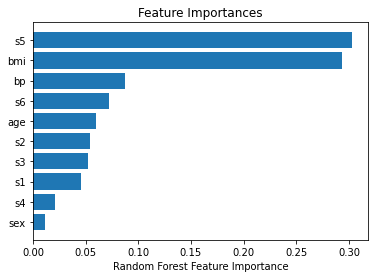

In [31]:
importances = model.feature_importances_
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

Scikit-learn also offers `SelectFromModel` class that helps you choose features directly from a given model.

You can also specify the threshold for coefficients or feature importance if you want and the 
maximum number of features you want to select.

In [32]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [33]:
# fetch a regression dataset
# in diabetes data we predict diabetes progression
# after one year based on some features
data = load_diabetes()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

In [34]:
# initialize the model
model = RandomForestRegressor()

In [35]:
# select from the model
sfm = SelectFromModel(estimator=model)
X_transformed = sfm.fit_transform(X, y)


In [36]:
# see which features were selected
support = sfm.get_support()

In [37]:
# get feature names
print([
 x for x, y in zip(col_names, support) if y == True
])

['bmi', 's5']


-  One more thing that we are missing here is feature selection using models that have L1 (Lasso) penalization. 
- When we have L1 penalization for regularization, most coefficients will be 0 (or close to 0), and we select the features with non-zero coefficients. 
- You can do it by just replacing random forest in the snippet of selection from a model with a model that supports 
L1 penalty, e.g. lasso regression.

- All tree-based models provide feature importance so all the model-based snippets shown can be used for XGBoost, 
LightGBM or CatBoost.

`Select features on  training data and validate the model on validation data for proper selection of features without overfitting the model.`


